In [30]:
import json

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from experiment_utils import EXPERIMENT_PATH


plt.style.use("ggplot")

In [68]:
experiment_path = EXPERIMENT_PATH / "baseline_1"
output_path = EXPERIMENT_PATH.parent / "analysis" / experiment_path.name
output_path.mkdir(exist_ok=True)

In [31]:
with open(experiment_path / "config.json") as f:
    config = json.load(f)

def get_experiment_specs(schema_id: int, workflow_id: int):
    return config["expanded_schemas"][schema_id], config["expanded_workflows"][workflow_id]

def get_schema_id(schema: dict):
    for i, s in enumerate(config["expanded_schemas"]):
        if s == schema:
            return i
    raise ValueError("Schema not found")

def get_workflow_id(workflow: dict):
    for i, w in enumerate(config["expanded_workflows"]):
        if w == workflow:
            return i
    raise ValueError(f"Workflow {workflow} not found")

def get_experiment(trial_id: int, schema: dict, workflow: dict) -> dict:
    schema_id = get_schema_id(schema)
    workflow_id = get_workflow_id(workflow)
    with open(experiment_path / f"trial{trial_id}_schema{schema_id}_workflow{workflow_id}.json") as f:
        experiment = json.load(f)
    for key, value in experiment.items():
        if isinstance(value, list):
            experiment[key] = np.array(value)
    return experiment

In [9]:
get_experiment_specs(0, 2)

({'index': 'HNSW', 'partitioner': 'mod', 'n_partitions': 5},
 {'selectivity': 0.01, 'filter_percentage': 0.9, 'k': 1000})

In [10]:
schema_id = 0
workflow_id = 0
trial_id = 0

experiment = experiment_path / f"trial{trial_id}_schema{schema_id}_workflow{workflow_id}.json"
with open(experiment, "r") as f:
    experiment_data = json.load(f)

schema, workflow = get_experiment_specs(schema_id, workflow_id)
schema_name = f"{schema["n_partitions"]}x {schema["partitioner"]}-partitioned {schema["index"]} index"
filter_name = f"{100*workflow["filter_percentage"]:.0f}% {workflow["selectivity"]}-selectivity filters"
experiment_name = f"{schema_name} with {filter_name}"

In [11]:
search_times = np.array(experiment_data["search_times"])
filter_used = np.array(experiment_data["filter_used"])

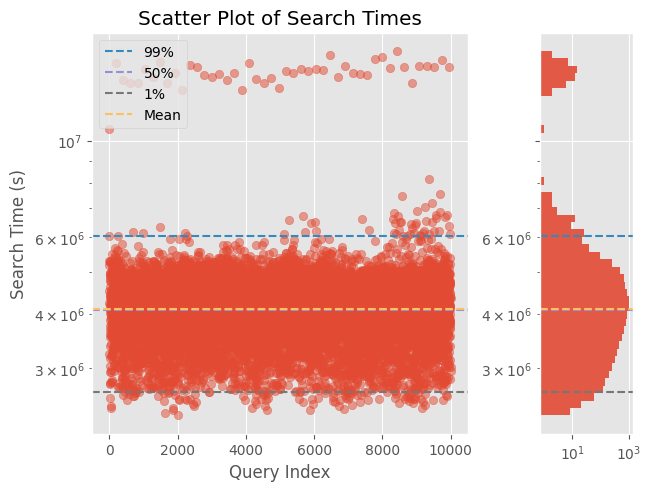

In [12]:
fig, axes = plt.subplot_mosaic(
    [["scatter", "histogram"]],
    layout="constrained",
    width_ratios=[4, 1],
    height_ratios=[1],
)

# Scatter plot
axes["scatter"].scatter(
    np.arange(len(search_times)), search_times, alpha=0.5
)
axes["scatter"].set_title("Scatter Plot of Search Times")
axes["scatter"].set_xlabel("Query Index")
axes["scatter"].set_ylabel("Search Time (s)")
axes["scatter"].set_yscale("log")
axes["histogram"].set_yscale("log")

# Histogram
bins = np.logspace(np.log10(search_times.min()), np.log10(search_times.max()), 50)
axes["histogram"].hist(
    search_times, bins=bins, alpha=0.9, orientation="horizontal"
)
axes["histogram"].set_xscale("log")
axes["histogram"].tick_params(axis="y", labelleft=False)

# Add a horizontal line for the 99th percentile
percentile_99 = np.percentile(search_times, 99)
percentile_1 = np.percentile(search_times, 1)
percentile_50 = np.percentile(search_times, 50)
mean = np.mean(search_times)
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
axes["scatter"].axhline(percentile_99, linestyle="--", label="99%", color=colors[1])
axes["scatter"].axhline(percentile_50, linestyle="--", label="50%", color=colors[2])
axes["scatter"].axhline(percentile_1, linestyle="--", label="1%", color=colors[3])
axes["scatter"].axhline(mean, linestyle="--", label="Mean", color=colors[4])
axes["scatter"].legend()

# Draw horizontal lines on the histogram for the percentiles
axes["histogram"].axhline(percentile_99, linestyle="--", color=colors[1])
axes["histogram"].axhline(percentile_50, linestyle="--", color=colors[2])
axes["histogram"].axhline(percentile_1, linestyle="--", color=colors[3])
axes["histogram"].axhline(mean, linestyle="--", color=colors[4])

plt.show()


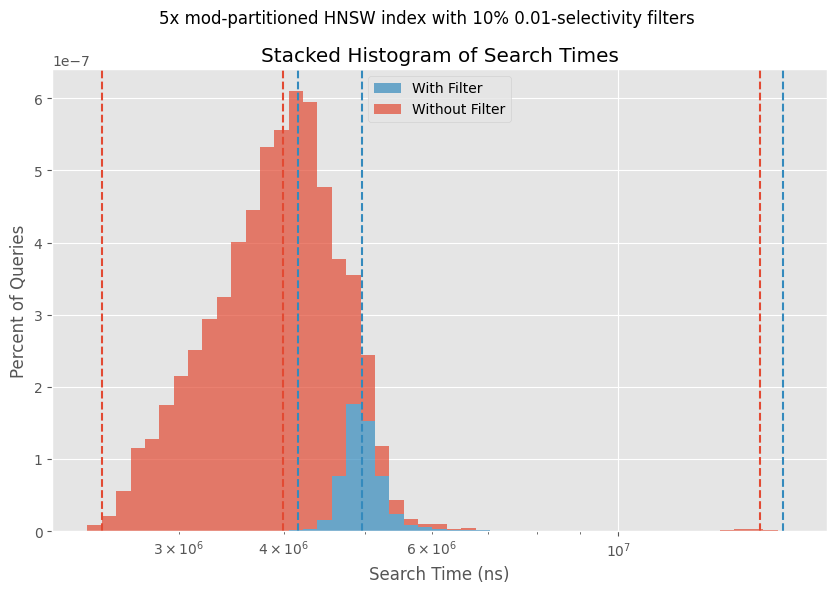

In [13]:
# Separate search times based on filter usage
search_times_with_filter = search_times[filter_used]
search_times_without_filter = search_times[~filter_used]

# Create a stacked histogram
plt.figure(figsize=(10, 6))
plt.hist(
    [search_times_with_filter, search_times_without_filter],
    bins=bins,
    stacked=True,
    label=["With Filter", "Without Filter"],
    color=[colors[1], colors[0]],
    alpha=0.7,
    density=True,
)
plt.title("Stacked Histogram of Search Times")
plt.suptitle(experiment_name)
plt.xlabel("Search Time (ns)")
plt.ylabel("Percent of Queries")
plt.xscale("log")

# Calculate percentiles for search times with and without filter
percentiles_with_filter = np.percentile(search_times_with_filter, [99.9, 50, .1])
percentiles_without_filter = np.percentile(search_times_without_filter, [99.9, 50, .1])

# Plot percentile lines for search times with filter
for p, label in zip(percentiles_with_filter, ["95% (With Filter)", "50% (With Filter)", "5% (With Filter)"]):
    plt.axvline(p, linestyle="--", color=colors[1])

# Plot percentile lines for search times without filter
for p, label in zip(percentiles_without_filter, ["95% (Without Filter)", "50% (Without Filter)", "5% (Without Filter)"]):
    plt.axvline(p, linestyle="--", color=colors[0])

plt.legend()
plt.show()

In [64]:
def split_cell_heatmap(data1, data2, cmap='viridis', figsize=(6, 6), show_percent_labels=True, colorbar_label='Value', xlabels=None, ylabels=None):
    """
    Plot a heatmap where each cell is split into two triangles,
    one for data1 (top-left) and one for data2 (bottom-right),
    sharing the same color scale.

    Parameters:
        data1 (ndarray): 2D array of values for top-left triangle.
        data2 (ndarray): 2D array of values for bottom-right triangle.
        cmap (str or Colormap): Matplotlib colormap to use.
        figsize (tuple): Size of the figure.
        show_percent_labels (bool): Whether to show % labels on axes.
        colorbar_label (str): Label for the shared colorbar.
    """
    assert data1.shape == data2.shape, "data1 and data2 must have the same shape"
    nrows, ncols = data1.shape

    fig, ax = plt.subplots(figsize=figsize)

    # Normalize both datasets on the same scale
    combined_min = min(data1.min(), data2.min())
    combined_max = max(data1.max(), data2.max())
    norm = plt.Normalize(combined_min, combined_max)
    cmap = plt.get_cmap(cmap)

    for i in range(nrows):
        for j in range(ncols):
            x, y = j, i

            # Top-left triangle (data1)
            triangle1 = patches.Polygon([
                [x, y + 1],
                [x, y],
                [x + 1, y + 1]
            ], closed=True, facecolor=cmap(norm(data1[i, j])), edgecolor='none')
            ax.add_patch(triangle1)

            # Bottom-right triangle (data2)
            triangle2 = patches.Polygon([
                [x + 1, y],
                [x + 1, y + 1],
                [x, y]
            ], closed=True, facecolor=cmap(norm(data2[i, j])), edgecolor='none')
            ax.add_patch(triangle2)

            # Add numeric labels
            ax.text(x + 0.25, y + 0.75, f"{data1[i, j]:.2e}", ha='center', va='center', fontsize=8, color='black')
            ax.text(x + 0.75, y + 0.25, f"{data2[i, j]:.2e}", ha='center', va='center', fontsize=8, color='black')

    # Axis labels
    if show_percent_labels:
        ax.set_xticks(np.arange(ncols) + 0.5)
        ax.set_xticklabels([f"{int(100*p)}%" for p in xlabels])
        ax.tick_params(axis='x', bottom=True, top=False, labelbottom=True)
        ax.set_xlabel("Filter Selectivity")

        ax.set_yticks(np.arange(nrows) + 0.5)
        ax.set_yticklabels([f"{int(100*p)}%" for p in ylabels])
        ax.tick_params(axis='y', left=True)
        ax.set_ylabel("Filter Percentage")

    else:
        ax.set_xticks([])
        ax.set_yticks([])

    ax.set_xlim(0, ncols)
    ax.set_ylim(0, nrows)
    ax.set_aspect('equal')

    # Shared colorbar
    sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    fig.colorbar(sm, ax=ax, fraction=0.035, pad=0.04, label=colorbar_label)

    plt.tight_layout()


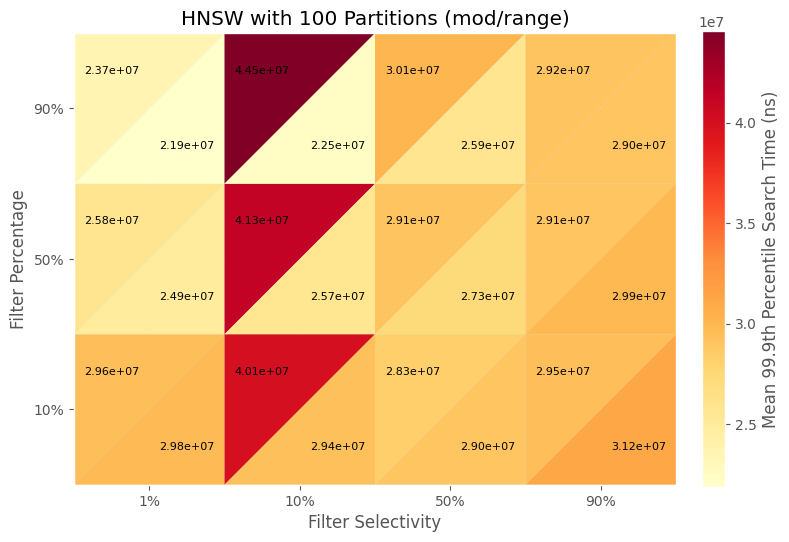

In [ ]:
target_schema = {
    "index": "IVF_FLAT",
    "partitioner": "mod",
    "n_partitions": 100,
}
target_workflow = {
    "filter_percentage": [0.1, 0.5, 0.9],
    "selectivity": [0.01, 0.1, 0.5, 0.9],
}

def get_heatmap_data(index: str, partitioner: str, n_partitions: int, percentile: float):
    target_workflow = {
        "filter_percentage": [0.1, 0.5, 0.9],
        "selectivity": [0.01, 0.1, 0.5, 0.9],
    }
    
    heatmap_data = np.zeros((len(target_workflow["filter_percentage"]), len(target_workflow["selectivity"])))
    for i, filter_percentage in enumerate(target_workflow["filter_percentage"]):
        for j, selectivity in enumerate(target_workflow["selectivity"]):
            percentiles = []
            for trial_id in range(config["trials"]):
                experiment_data = get_experiment(
                    trial_id,
                    {
                        "index": index,
                        "partitioner": partitioner,
                        "n_partitions": n_partitions,
                    },
                    {
                        "filter_percentage": filter_percentage,
                        "selectivity": selectivity,
                        "k": 1000,
                    },
                )
                percentiles.append(np.percentile(experiment_data["search_times"], percentile))

            heatmap_data[i, j] = np.mean(percentiles)
    return heatmap_data

for index in ["IVF_FLAT", "HNSW"]:
    for n_partitions in [5, 10, 100]:
        for percentile in [99.9, 50]:
            hm1 = get_heatmap_data(index, "mod", n_partitions, percentile)
            hm2 = get_heatmap_data(index, "range", n_partitions, percentile)
            split_cell_heatmap(hm1, hm2, cmap='YlOrRd', figsize=(8, 8), show_percent_labels=True, colorbar_label=f"Mean {percentile}th Percentile Search Time (ns)", xlabels=target_workflow["selectivity"], ylabels=target_workflow["filter_percentage"])
            plt.tight_layout()
            plt.title(f"{index} with {n_partitions} Partitions (mod/range)")
            plt.savefig(output_path / f"{index}_{n_partitions}_mod_range_{percentile}.png")
            plt.show()

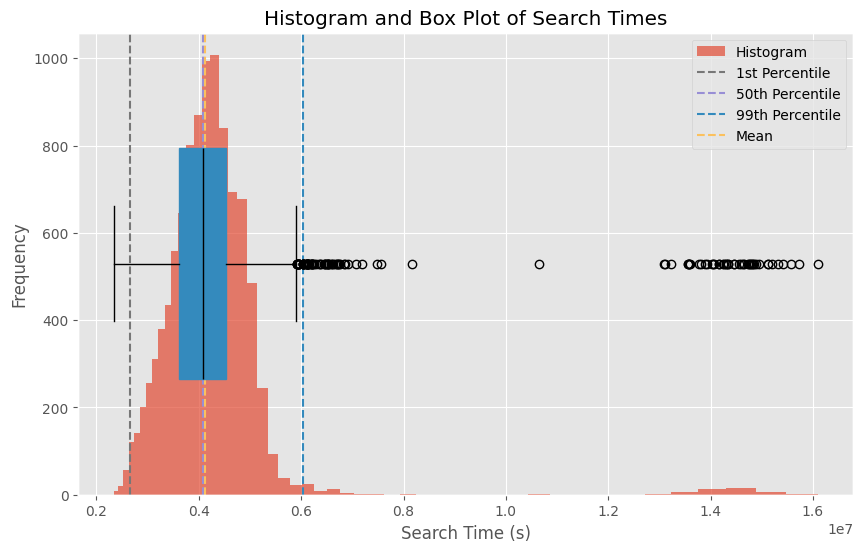

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot histogram
ax.hist(search_times, bins=bins, alpha=0.7, label="Histogram", color=colors[0])

# Create a twin axis for the box plot
ax_box = ax.twinx()

# Plot box plot
ax_box.boxplot(search_times, vert=False, widths=0.5, patch_artist=True,
               boxprops=dict(facecolor=colors[1], color=colors[1]),
               medianprops=dict(color="black"))

# Set labels and title
ax.set_title("Histogram and Box Plot of Search Times")
ax.set_xlabel("Search Time (s)")
ax.set_ylabel("Frequency")
ax_box.set_yticks([])  # Hide y-axis ticks for the box plot

# Plot vertical lines for the percentiles
ax.axvline(percentile_1, linestyle="--", color=colors[3], label="1st Percentile")
ax.axvline(percentile_50, linestyle="--", color=colors[2], label="50th Percentile")
ax.axvline(percentile_99, linestyle="--", color=colors[1], label="99th Percentile")
ax.axvline(mean, linestyle="--", color=colors[4], label="Mean")

ax.legend()
plt.show()

NameError: name 'filter_colors' is not defined

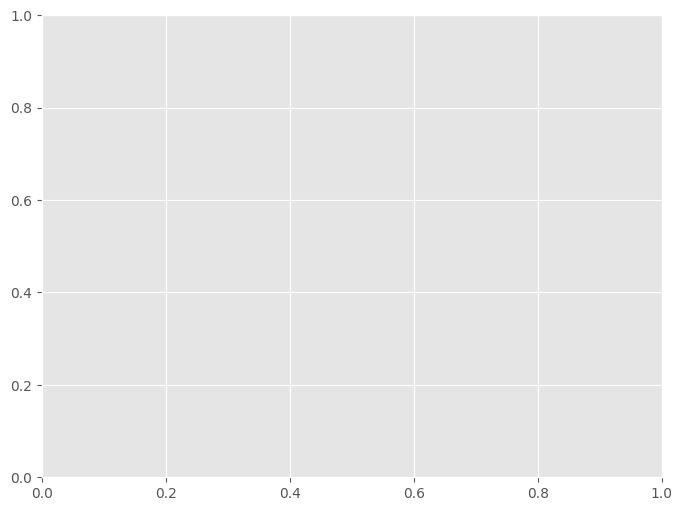

In [16]:
fig, ax = plt.subplots(figsize=(8, 6))

# Separate search times based on filter usage
search_times_with_filter = search_times[filter_used]
search_times_without_filter = search_times[~filter_used]

# Create box plots
ax.boxplot(
    [search_times_without_filter, search_times_with_filter],
    labels=["Without Filter", "With Filter"],
    patch_artist=True,
    boxprops=dict(facecolor=filter_colors[0], color=filter_colors[0]),
    medianprops=dict(color="black"),
)

ax.set_title("Comparison of Search Times")
ax.set_ylabel("Search Time (s)")

plt.show()

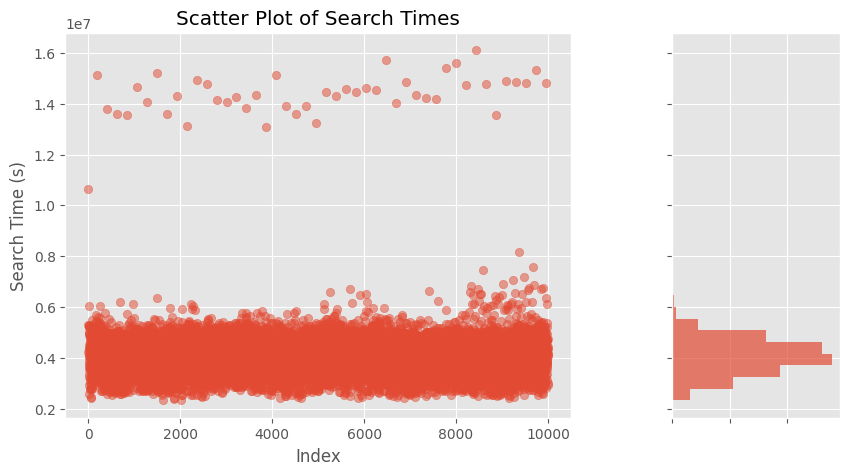

In [17]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(10, 5))
gs = GridSpec(1, 2, width_ratios=[3, 1], wspace=0.3)

# Scatter plot
ax_scatter = fig.add_subplot(gs[0])
ax_scatter.scatter(range(len(search_times)), search_times, alpha=0.5)
ax_scatter.set_title("Scatter Plot of Search Times")
ax_scatter.set_xlabel("Index")
ax_scatter.set_ylabel("Search Time (s)")

# Histogram
ax_hist = fig.add_subplot(gs[1])
ax_hist.hist(search_times, bins=30, orientation='horizontal', alpha=0.7, density=True)
ax_hist.set_xticklabels([])
ax_hist.set_yticklabels([])

plt.show()